In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, Concatenate, UpSampling2D, BatchNormalization, Activation, Conv2DTranspose, Add, MaxPool2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import gc


In [3]:
# Read and examine metadata
raw_data = pd.read_csv(r'../COVID-19 Lung CT Scan Segmentation/COVID-19 Lung CT Scan Segmentation/metadata_temp.csv')
raw_data.sample(5)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
8,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
16,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
15,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
6,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
4,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...


In [4]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [5]:
# Read sample
sample_ct   = read_nii(raw_data.loc[1,'ct_scan'])
sample_lung = read_nii(raw_data.loc[1,'lung_mask'])
sample_infe = read_nii(raw_data.loc[1,'infection_mask'])
sample_all  = read_nii(raw_data.loc[1,'lung_and_infection_mask'])

# Examine Shape
sample_ct.shape

(512, 512, 200)

Text(0.5, 1.0, 'Lung and Infection Mask')

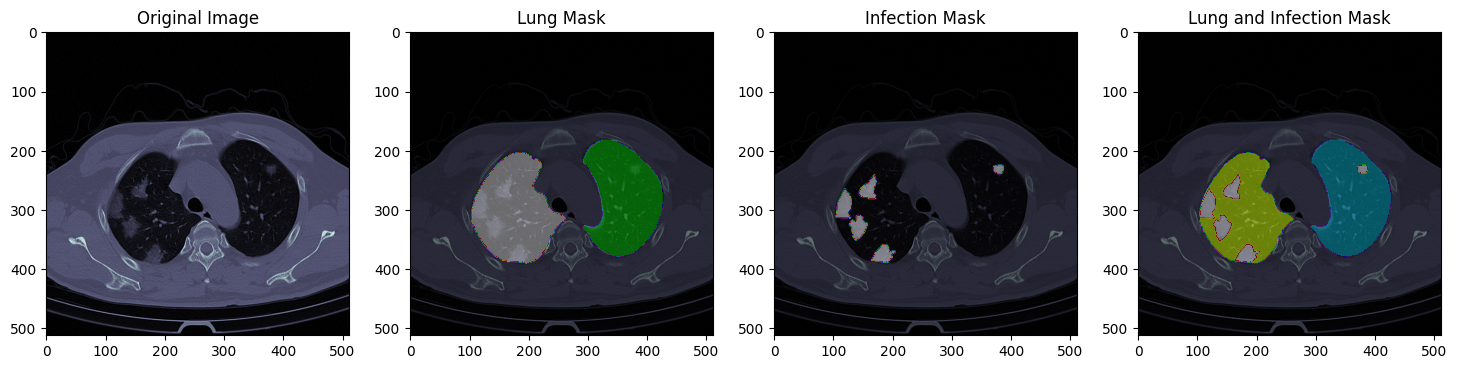

In [6]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_lung[..., 150],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung Mask')

plt.subplot(1,4,3)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_infe[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Infection Mask')

plt.subplot(1,4,4)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_all[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung and Infection Mask')

In [7]:
IMG_SIZE = 128
IMG_HEIGHT = IMG_SIZE
IMG_WIDTH = IMG_SIZE
IMG_CHANNELS = 1

In [8]:
def get_data():
    lungs_data = []
    infections_data  = []

    for row in range(len(raw_data)):
        lungs_image = read_nii(raw_data['ct_scan'][row])
        infection_image = read_nii(raw_data['infection_mask'][row])

        for slice_no in range(lungs_image.shape[2]):
            lung_slice = cv2.resize(lungs_image[..., slice_no], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
            infection_slice = cv2.resize(infection_image[..., slice_no], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            lungs_data.append(lung_slice[..., np.newaxis])
            infections_data.append(infection_slice[..., np.newaxis])
    return lungs_data, infections_data

In [9]:
data = get_data()
lungs = np.array(data[0])
infections = np.array(data[1])

Text(0.5, 1.0, 'Transformed Infection Mask')

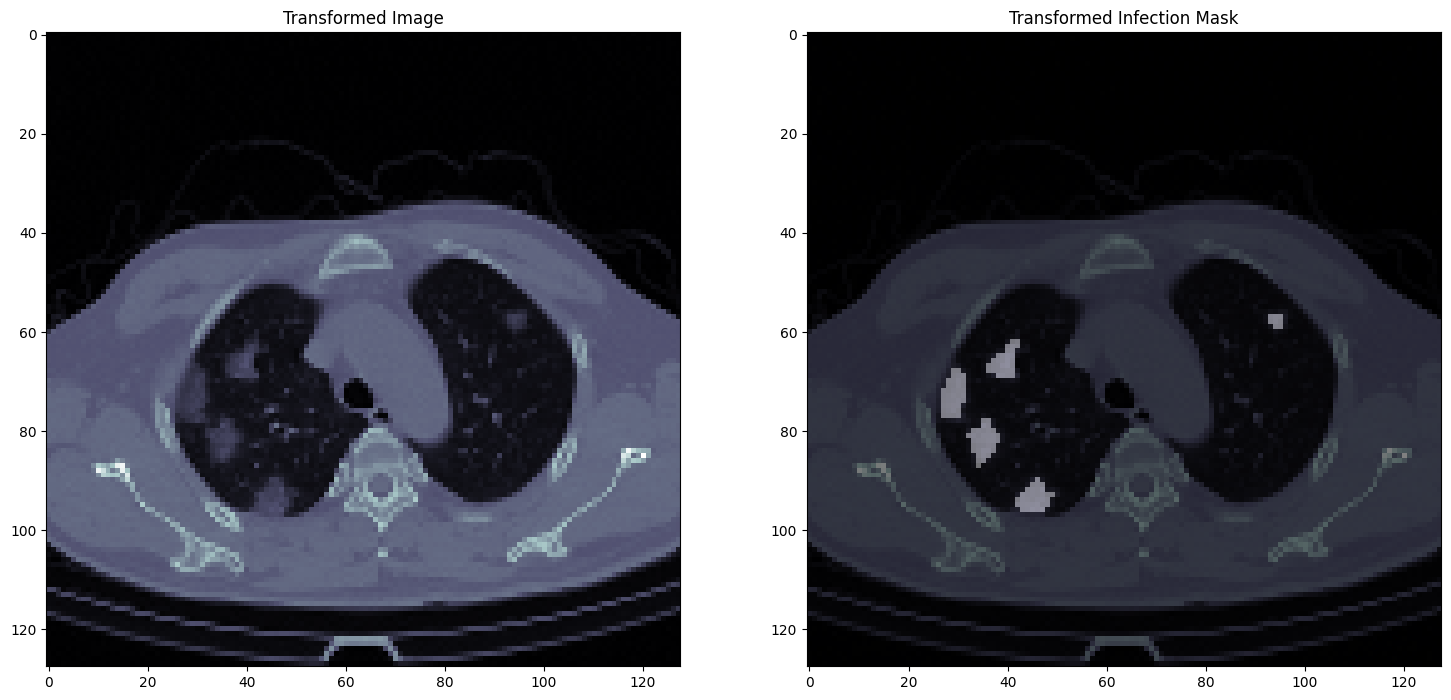

In [10]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,2,1)
plt.imshow(lungs[451], cmap = 'bone')
plt.title('Transformed Image')

plt.subplot(1,2,2)
plt.imshow(lungs[451], cmap = 'bone')
plt.imshow(infections[451],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Transformed Infection Mask')

In [11]:
# Split the data into train and test sets
lung_train, lung_test, infect_train, infect_test = train_test_split(lungs, infections, test_size=0.1, shuffle=True)


In [12]:
lung_train.shape, lung_test.shape, infect_train.shape, infect_test.shape

((3168, 128, 128, 1),
 (352, 128, 128, 1),
 (3168, 128, 128, 1),
 (352, 128, 128, 1))

In [13]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = Conv2D(num_filters, 1, padding="same")(g)
    Wg = BatchNormalization()(Wg)

    Ws = Conv2D(num_filters, 1, padding="same")(s)
    Ws = BatchNormalization()(Ws)

    out = Activation("relu")(Wg + Ws)
    out = Conv2D(num_filters, 1, padding="same")(out)
    out = Activation("sigmoid")(out)

    return out * s

def decoder_block(x, s, num_filters):
    x = UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def attention_unet(input_shape):
    """ Inputs """
    inputs = Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    b1 = conv_block(p3, 512)

    """ Decoder """
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model


In [14]:
if __name__ == "__main__":
    input_shape = (128, 128, 1)
    model = attention_unet(input_shape)
    model.summary()

Model: "Attention-UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                    

In [15]:
import tensorflow.keras.backend as K

def jaccard_loss(y_true, y_pred, smooth=1e-7):
    y_true = K.cast(y_true, dtype='float32')  # Cast y_true to float32
    intersection = K.sum(y_true * y_pred, axis=(1, 2, 3))
    union = K.sum(y_true, axis=(1, 2, 3)) + K.sum(y_pred, axis=(1, 2, 3)) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return 1 - jaccard

In [16]:
from keras import backend as K
K.clear_session()
metrics = ["accuracy",
           tf.keras.metrics.AUC(),
           tf.keras.metrics.SensitivityAtSpecificity(0.5),
           tf.keras.metrics.SpecificityAtSensitivity(0.5),
           tf.keras.metrics.MeanIoU(num_classes=2)]  # Use MeanIoU as the Jaccard Index metric
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)  # Use custom Jaccard loss

gc.collect()

0

In [17]:
model.summary()

Model: "Attention-UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                    

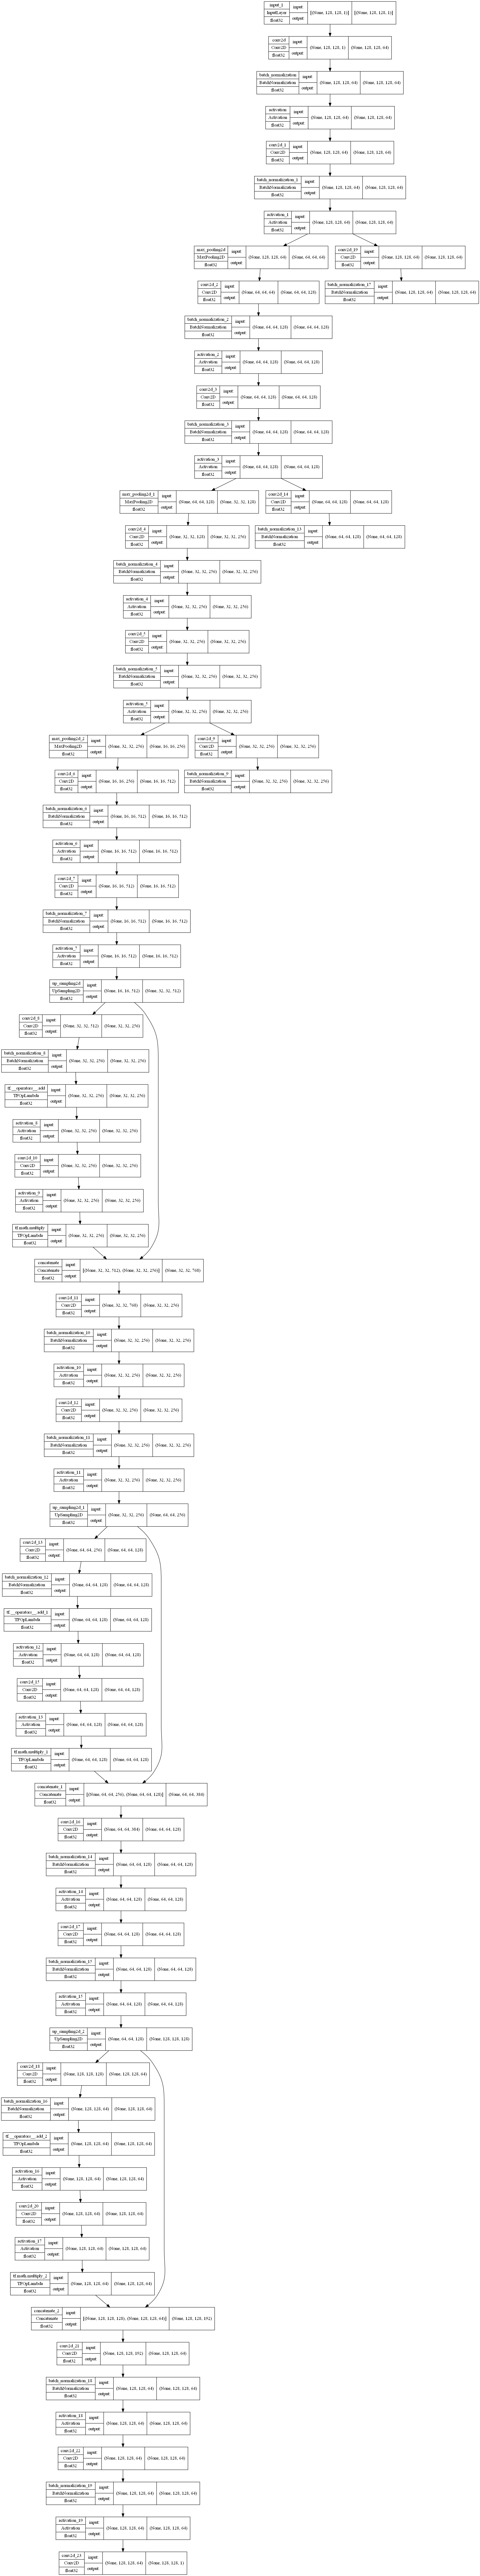

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [19]:
# Define callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
]


In [20]:
results = model.fit(lung_train, infect_train, batch_size=8, epochs=50, callbacks=callbacks, validation_data=(lung_test, infect_test), use_multiprocessing=True)


Epoch 1/50


KeyboardInterrupt: 

In [ ]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,mean_io_u,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,val_mean_io_u,lr
46,0.003786,0.998399,0.998802,0.998271,0.999979,0.496717,0.005289,0.997893,0.995095,0.991260,0.999932,0.496568,0.00001
39,0.003865,0.998369,0.998646,0.997987,0.999978,0.496718,0.005404,0.997847,0.994891,0.990907,0.999933,0.496568,0.00001
49,0.003763,0.998412,0.998711,0.998081,0.999982,0.496717,0.005449,0.997851,0.994757,0.990629,0.999928,0.496568,0.00001
48,0.003762,0.998414,0.998790,0.998239,0.999982,0.496718,0.005484,0.997828,0.994864,0.990856,0.999934,0.496568,0.00001
42,0.003823,0.998387,0.998767,0.998216,0.999979,0.496718,0.005509,0.997799,0.995303,0.991765,0.999933,0.496568,0.00001
37,0.003869,0.998372,0.998733,0.998163,0.999978,0.496717,0.005519,0.997806,0.994807,0.990780,0.999932,0.496568,0.00001
32,0.004233,0.998222,0.998414,0.997667,0.999970,0.496718,0.005544,0.997773,0.994302,0.989820,0.999929,0.496568,0.00010
38,0.003861,0.998371,0.998760,0.998216,0.999979,0.496718,0.005544,0.997795,0.994847,0.990856,0.999922,0.496568,0.00001
35,0.003909,0.998352,0.998753,0.998219,0.999976,0.496717,0.005563,0.997763,0.995098,0.991386,0.999918,0.496568,0.00001
36,0.003907,0.998354,0.998663,0.998037,0.999975,0.496717,0.005570,0.997768,0.994972,0.991134,0.999923,0.496568,0.00001


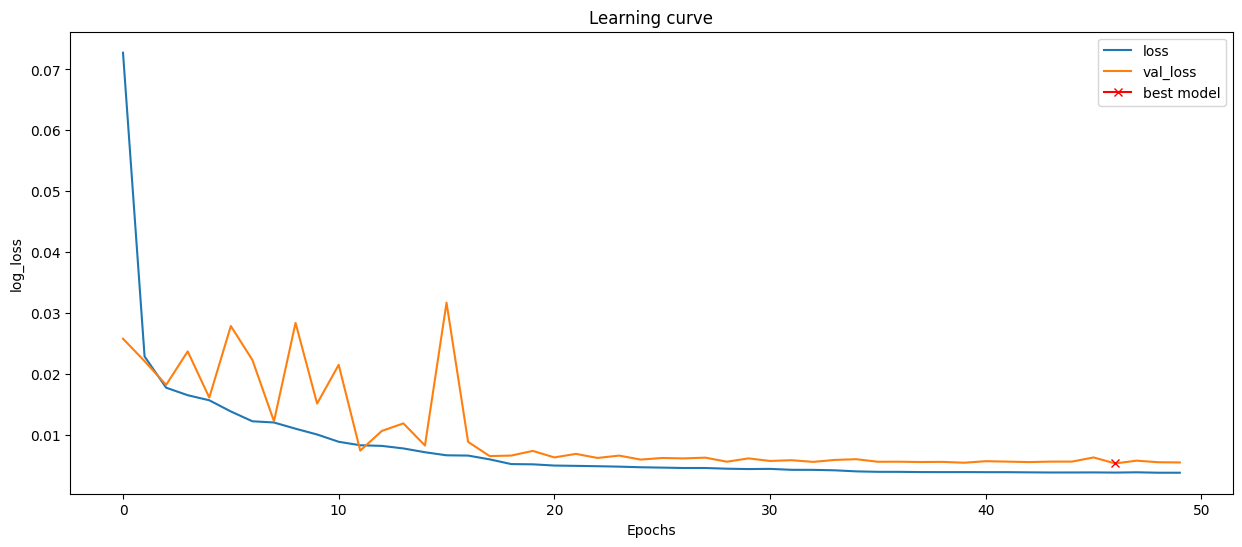

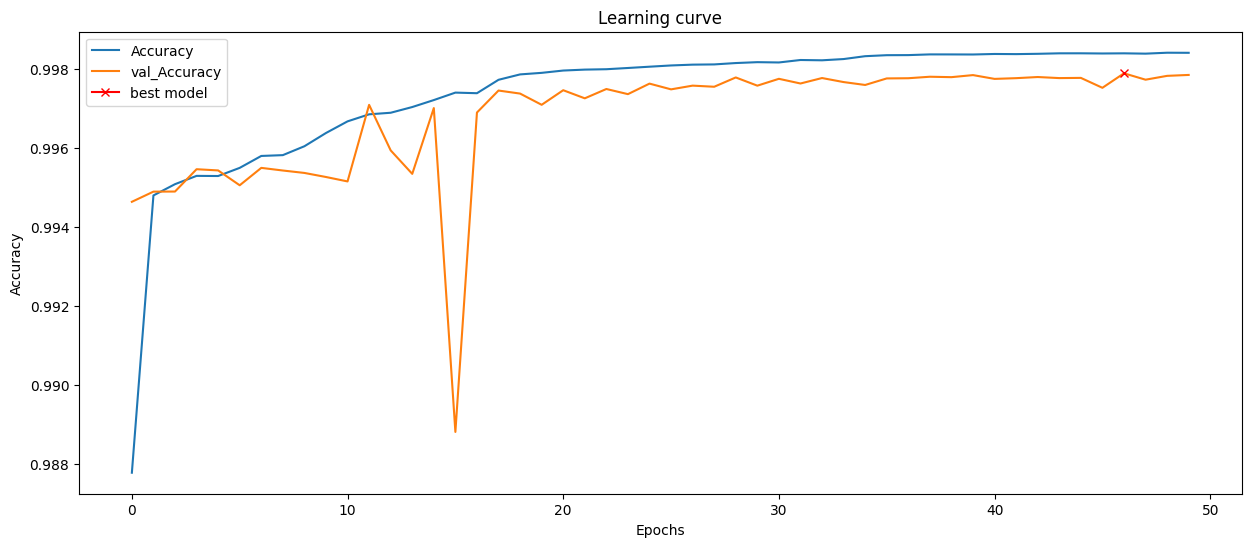

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();


In [ ]:
# Calculate metrics
predicted = model.predict(lung_test)

# Flatten the predicted and true masks
predicted_flat = np.round(predicted.flatten())
infect_test_flat = infect_test.flatten()

11/11 [==============================] - 8s 137ms/step


In [ ]:
# Calculate metrics for training data
train_predicted = model.predict(lung_train)

# Flatten the predicted and true masks
train_predicted_flat = np.round(train_predicted.flatten())
infect_train_flat = infect_train.flatten()

# Calculate precision and recall for training data
train_precision = Precision()
train_recall = Recall()
train_precision.update_state(infect_train_flat, train_predicted_flat)
train_recall.update_state(infect_train_flat, train_predicted_flat)

# Calculate F1 score for training data
train_f1_score = 2 * (train_precision.result() * train_recall.result()) / (train_precision.result() + train_recall.result())

# Calculate accuracy for training data
train_accuracy = np.mean(train_predicted_flat == infect_train_flat)

# Calculate metrics for testing data
test_predicted = model.predict(lung_test)

# Flatten the predicted and true masks for testing data
test_predicted_flat = np.round(test_predicted.flatten())
infect_test_flat = infect_test.flatten()

# Calculate precision and recall for testing data
test_precision = Precision()
test_recall = Recall()
test_precision.update_state(infect_test_flat, test_predicted_flat)
test_recall.update_state(infect_test_flat, test_predicted_flat)

# Calculate F1 score for testing data
test_f1_score = 2 * (test_precision.result() * test_recall.result()) / (test_precision.result() + test_recall.result())

# Calculate accuracy for testing data
test_accuracy = np.mean(test_predicted_flat == infect_test_flat)

# Calculate parameters
total_parameters = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])

# Calculate FLOPs
# flops = get_flops(model, batch_size=1)  # Assuming batch_size = 1

# Print the metrics for training data
print("Training Metrics:")
print("Precision: ", train_precision.result().numpy())
print("Recall: ", train_recall.result().numpy())
print("F1 Score: ", train_f1_score.numpy())
print("Accuracy: ", train_accuracy)

# Print the metrics for testing data
print("\nTesting Metrics:")
print("Precision: ", test_precision.result().numpy())
print("Recall: ", test_recall.result().numpy())
print("F1 Score: ", test_f1_score.numpy())
print("Accuracy: ", test_accuracy)

# Print the other metrics
print("\nTotal Parameters: ", total_parameters)
# print("FLOPs: ", flops)


11/11 [==============================] - 2s 154ms/step
Training Metrics:
Precision:  0.8692235
Recall:  0.8482986
F1 Score:  0.8586336
Accuracy:  0.9981661902533637

Testing Metrics:
Precision:  0.8462067
Recall:  0.83960193
F1 Score:  0.8428914
Accuracy:  0.9978514584628019

Total Parameters:  8134593


In [ ]:
# Calculate Jaccard Index (MeanIoU) for training data
train_iou = tf.keras.metrics.MeanIoU(num_classes=2)
train_iou.update_state(infect_train_flat, train_predicted_flat)
train_mean_iou = train_iou.result().numpy()

# Calculate Jaccard Index (MeanIoU) for testing data
test_iou = tf.keras.metrics.MeanIoU(num_classes=2)
test_iou.update_state(infect_test_flat, test_predicted_flat)
test_mean_iou = test_iou.result().numpy()

# Print the Jaccard Index (MeanIoU) for training and testing data
print("Training Jaccard Index (MeanIoU): ", train_mean_iou)
print("Testing Jaccard Index (MeanIoU): ", test_mean_iou)


Training Jaccard Index (MeanIoU):  0.8733221
Testing Jaccard Index (MeanIoU):  0.8631426


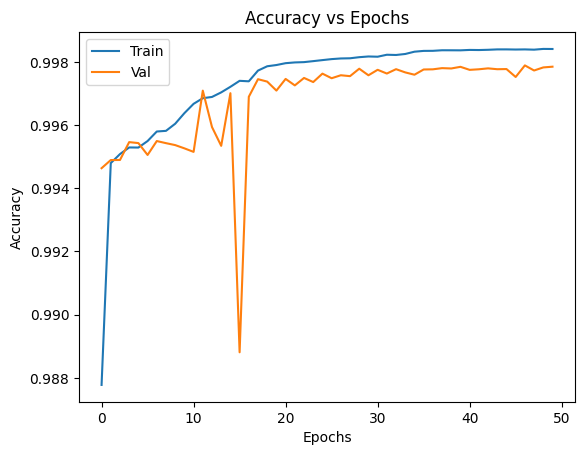

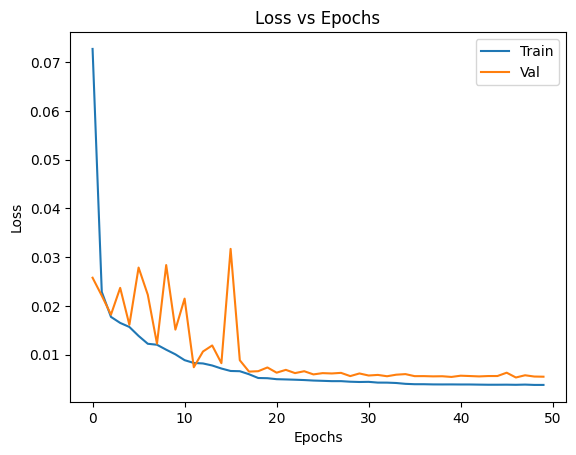

In [ ]:
# Plot accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [ ]:
# Make predictions
predicted = model.predict(lung_test)

11/11 [==============================] - 2s 154ms/step


11/11 [==============================] - 2s 152ms/step


Text(0.5, 1.0, 'Predicted infection mask')

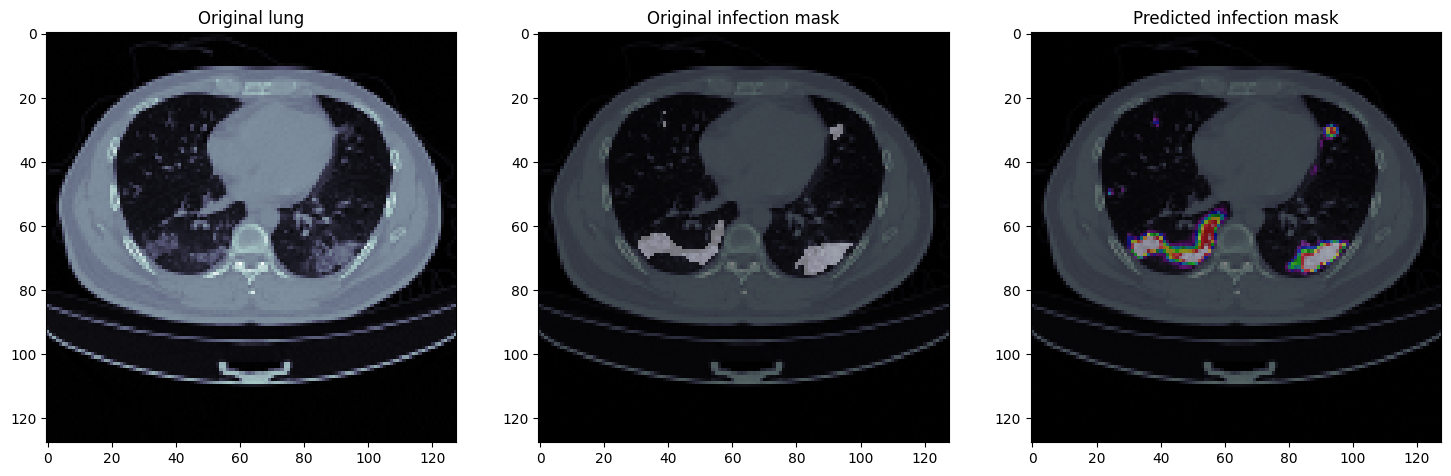

In [ ]:
# Make predictions and visualize
img_num = 5
predicted = model.predict(lung_test)

# Visualize results
fig = plt.figure(figsize=(18, 15))
plt.subplot(1, 3, 1)
plt.imshow(lung_test[img_num], cmap='bone')
plt.title('Original lung')

plt.subplot(1, 3, 2)
plt.imshow(lung_test[img_num], cmap='bone')
plt.imshow(infect_test[img_num][..., 0], alpha=0.5, cmap="nipy_spectral")
plt.title('Original infection mask')

plt.subplot(1, 3, 3)
plt.imshow(lung_test[img_num], cmap='bone')
plt.imshow(predicted[img_num], alpha=0.5, cmap="nipy_spectral")
plt.title('Predicted infection mask')

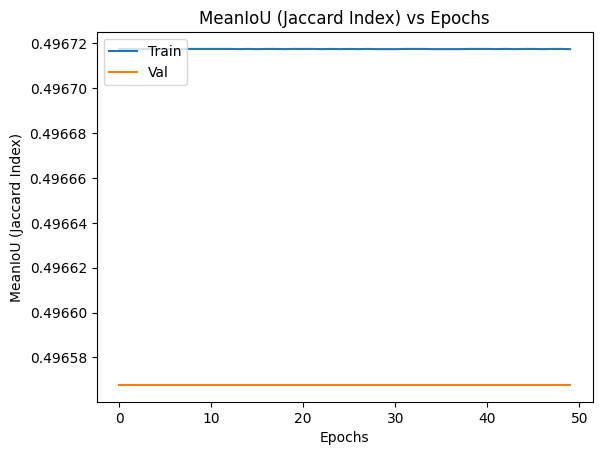

In [ ]:
# Plot Jaccard Index (MeanIoU)
plt.plot(results.history['mean_io_u'])
plt.plot(results.history['val_mean_io_u'])
plt.title('MeanIoU (Jaccard Index) vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MeanIoU (Jaccard Index)')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
model.save_weights("Attention_Unet.h5")